# CTM Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import datetime

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()

In [2]:
def cp_outflow(c, pk, rek, sbk, sck):
    return np.min([np.median([pk * rek, sbk, rek - sck]), c.vf * c.oldk * c.time_hour / c.length])


def cp_outflow_cto(c):
    return np.min([c.cto[0].qmax, c.oldk * c.vf, c.cto[0].w * (c.cto[0].kjam - c.cto[0].oldk)]) * c.time_hour / c.length


def cp_outflow_no_cto(c):
    return np.min([c.qmax, c.oldk * c.vf, c.dis_rate]) * c.time_hour / c.length


def cp_outflow_cfrom(sbk, rek, ptdc, rck, ptnc):
    return np.min([sbk, rek/ptdc, rck/ptnc])


def cp_inflow(c):
    return np.min([c.qmax, c.vf * c.cfrom[0].oldk, c.w * (c.kjam - c.oldk)]) * c.time_hour / c.length


def cp_inflow_no_cfrom(c):
    return np.min([c.qmax, c.arr_rate, c.w * (c.kjam - c.oldk)]) * c.time_hour / c.length


def cp_inflow_cto(c, sbk, sck):
    return np.min([c.qmax * c.time_hour / c.length, sbk+sck, c.w * (c.kjam - c.oldk) * c.time_hour / c.length])


def cp_inflow_basic(c):
    return np.min([c.qmax, c.vf * c.oldk]) * c.time_hour / c.length


def cp_inflow_basic_diff(c):
    return np.min([c.qmax, c.w * (c.kjam - c.oldk)]) * c.time_hour / c.length

def cp_inflow_next_c(ptnc, sbk, rek, ptdc, rck):
    return ptnc * np.min([sbk, rek/ptdc, rck/ptnc])


def cp_density(c):
    return c.oldk + np.max([0, c.inflow]) - np.max([0, c.outflow])

In [3]:
class Cell(object):
    idcase = {}                               #time_interval=6       qmax=2160, kjam=220 *original
    def __init__(self, cellid, linkid, zoneid, time_interval=5, k=0, qmax=9863, kjam=1051, 
                 vf=85, w=12, length=0.1, arr_rate=0, dis_rate=0):
        self.kjam = kjam
        self.cellid = cellid # local address
        self.linkid = linkid # link layer address
        self.zoneid = zoneid # zone layer address
        self.vf = vf # Time interval = length / vf   * delta i = length of segment - constant/ v_max, vf is Vfree?
        self.w = w # weight?
        self.cfrom = [] # cell from
        self.cto = [] # cell to 
        self.k = k # density at time interval t
        self.oldk = k # density at time interval t-1
        self.qmax = qmax
        self.length = length
        self.updated = False
        self.arr_rate = arr_rate # arrival rate?
        self.dis_rate = dis_rate # distance rate
        self.time_sec = time_interval
        self.time_hour = time_interval / 3600
        self.inflow = 0
        self.outflow = 0
        self.pk = 0.75 # flow-density ratio ?
        self.pck = 0.25 # flow capacity to 
        if Cell.idcase.get(self.getCompleteAddress()) == None:
            Cell.idcase.setdefault(self.getCompleteAddress(), self)
        else:
            raise Exception("This id has been used by other cell")
        
    def addConnection(self, sink):
        if len(sink.cfrom) == 2 or len(self.cto) == 2:
            raise Exception("Cannot add more connection to cell %s and cell %s" % (self.getCompleteAddress(), sink.getCompleteAddress())) 
            
        if (len(self.cto) and len(sink.cfrom)) and (len(sink.cto) == 2 or len(self.cfrom) == 2):
            raise Exception("Invaild cell connection! A cell cannot connect to merge and diverge cell simultaneously")
            
        self.cto.append(sink) # An instance of cell class is stored, in order to use cto and cfrom as pointer.
        sink.cfrom.append(self)
        
    def deleteConnection(self, sink):
        if sink not in self.cto:
            raise Exception("Cell %s is not connected with cell %s" % (self.getCompleteAddress(), sink.getCompleteAddress()))
            
        self.cto.remove(sink)
        sink.cfrom.remove(self)
        
    def getCell(cid):
        return Cell.idcase[cid]
    
    def getFirstCell(linkid):
        newDict = {}
        for key in Cell.idcase:
            if Cell.idcase[key].linkid == linkid:
                newDict[key] = Cell.idcase[key]
                
        return newDict[min(newDict.keys())]
    
    def getLastCell(linkid):
        newDict = {}
        for key in Cell.idcase:
            if Cell.idcase[key].linkid == linkid:
                newDict[key] = Cell.idcase[key]
                
        return newDict[max(newDict.keys())]
    
    def deleteCell(cid):
        poped = Cell.idcase.pop(cid)
        for elem in poped.cto:
            poped.deleteConnection(elem)
        del poped
        
    def getCompleteAddress(self):
        return "%s.%s.%s" % (self.zoneid, self.linkid, self.cellid)
    
    def updateDensity(self): # This method can only be used by normal cell instance.
        if not self.updated:
            self.oldk = self.k
        if len(self.cfrom) == 2: # Merge at here, we need to update density among this cell and two other upstream cells.
            pk = self.pk # probability from upstream normal cell
            pck = 1 - self.pk # probability from upstream merge cell
            for elem in self.cfrom:
                rek = cp_inflow_basic_diff(c=self)                                    # np.min([self.qmax, self.w * (self.kjam - self.oldk)]) * self.time_hour / self.length
                if elem.linkid == self.linkid:
                    sbk = cp_inflow_basic(c=elem)                                     # np.min([elem.qmax, elem.vf * elem.oldk]) * elem.time_hour / elem.length
                    prov = elem
                    
                else:
                    sck = cp_inflow_basic(c=elem)                                     # np.min([elem.qmax, elem.vf * elem.oldk]) * elem.time_hour / elem.length
                    if not elem.updated:
                        elem.oldk = elem.k
                        
                    merge = elem
            
            # try: # In order to cope with situation that previous cell is the first cell (cfrom is empty)
            if len(prov.cfrom):    
                prov.inflow = cp_inflow(c=prov)                                        # np.min([prov.qmax, prov.vf * prov.cfrom[0].oldk, prov.w * (prov.kjam - prov.oldk)]) * prov.time_hour / prov.length
                prov.outflow = cp_outflow(c=prov, pk=pk, rek=rek, sbk=sbk, sck=sck)    # np.min([np.median([pk * rek, sbk, rek - sck]), prov.vf * prov.oldk * prov.time_hour / prov.length])
            else:
                prov.inflow = cp_inflow_no_cfrom(c=prov)                               # np.min([prov.qmax, prov.arr_rate, prov.w * (prov.kjam - prov.oldk)]) * prov.time_hour / prov.length
                prov.outflow = cp_outflow(c=prov, pk=pk, rek=rek, sbk=sbk, sck=sck)    # np.min([np.median([pk * rek, sbk, rek - sck]), prov.vf * prov.oldk * prov.time_hour / prov.length])
                    
            if len(merge.cfrom): # if there are connections from,                
                merge.inflow = cp_inflow(c=merge)                                      # np.min([merge.qmax, merge.vf * merge.cfrom[0].oldk, merge.w * (merge.kjam - merge.oldk)]) * merge.time_hour / merge.length
                merge.outflow = cp_outflow(c=merge, pk=pk, rek=rek, sbk=sbk, sck=sck)  # merge.outflow = np.min([np.median([pck * rek, sck, rek - sbk]), merge.vf * merge.oldk * merge.time_hour / merge.length])
            else:
                merge.inflow = cp_inflow_no_cfrom(c=merge)                             # np.min([merge.qmax, merge.arr_rate, merge.w * (merge.kjam - merge.oldk)]) * merge.time_hour / merge.length
                merge.outflow = cp_outflow(c=merge, pk=pk, rek=rek, sbk=sbk, sck=sck)  # np.min([np.median([pck * rek, sck, rek - sbk]), merge.vf * merge.oldk * merge.time_hour / merge.length])
                
            if len(self.cto):   # if there are connections to,                
                self.inflow = cp_inflow_cto(c=self, sbk=sbk, sck=sck)                  # np.min([self.qmax * self.time_hour / self.length, sbk+sck, self.w * (self.kjam - self.oldk) * self.time_hour / self.length])
                self.outflow = cp_outflow_cto(c=self)                                  # np.min([self.cto[0].qmax, self.oldk * self.vf, self.cto[0].w * (self.cto[0].kjam - self.cto[0].oldk)]) * self.time_hour / self.length
            else:
                self.inflow = cp_inflow_cto(c=self, sbk=sbk, sck=sck)                  # np.min([self.qmax * self.time_hour / self.length, sbk+sck, self.w * (self.kjam - self.oldk) * self.time_hour / self.length])
                self.outflow = cp_outflow_no_cto(c)                                    # np.min([self.qmax, self.oldk * self.vf, self.dis_rate]) * self.time_hour / self.length
            
            prov.k = cp_density(c=prov)                                                # prov.oldk + np.max([0, prov.inflow]) - np.max([0, prov.outflow])
            merge.k = cp_density(c=merge)                                              # merge.oldk + np.max([0, merge.inflow]) - np.max([0, merge.outflow])
            self.k = cp_density(c=self)                                                # self.oldk + np.max([0, self.inflow]) - np.max([0, self.outflow])
            
            prov.updated, self.updated, merge.updated = True, True, True
            
        elif len(self.cto) == 2: # Diverge at here
            ptnc = self.pk # Propotion towards to next normal cell
            ptdc = 1 - self.pk # Propotion towards to diverge cell
            for elem in self.cto:
                if elem.linkid == self.linkid:
                    elem.oldk = elem.k
                    next_c = elem
                
                else:
                    if not elem.updated:
                        elem.oldk = elem.k
                        
                    diverge = elem
            
            rck = cp_inflow_basic_diff(c=next_c)            # np.min([next_c.qmax, next_c.w * (next_c.kjam - next_c.oldk)]) * next_c.time_hour / next_c.length # Receive ability of next normal cell
            rek = cp_inflow_basic_diff(c=diverge)           # np.min([diverge.qmax, diverge.w * (diverge.kjam - diverge.oldk)]) * diverge.time_hour / diverge.length
            sbk = cp_inflow_basic(c=self)                   # np.min([self.qmax, self.vf * self.oldk]) * self.time_hour / self.length
            
            if len(next_c.cto): # try:# In order to cope with situation that next cell is the last cell (cto is empty)
                next_c.inflow = cp_inflow_next_c(ptnc=ptnc, sbk=sbk, rek=rek, ptdc=ptdc, rck=rck)  # ptnc * np.min([sbk, rek/ptdc, rck/ptnc])
                next_c.outflow = cp_outflow_cto(c=next_c)   # np.min([next_c.cto[0].qmax, next_c.vf * next_c.oldk, next_c.cto[0].w * (next_c.cto[0].kjam - next_c.cto[0].oldk)]) * next_c.time_hour / next_c.length
            else:
                next_c.inflow = cp_inflow_next_c(ptnc=ptnc, sbk=sbk, rek=rek, ptdc=ptdc, rck=rck)   # ptnc * np.min([sbk, rek/ptdc, rck/ptnc])
                next_c.outflow = cp_outflow_no_cto(c=next_c) # np.min([next_c.qmax, next_c.vf * next_c.oldk, next_c.dis_rate]) * next_c.time_hour / next_c.length
            
            if len(diverge.cto):
                diverge.inflow = cp_inflow_next_c(ptnc=ptnc, sbk=sbk, rek=rek, ptdc=ptdc, rck=rck)  # ptdc * np.min([sbk, rek/ptdc, rck/ptnc])
                diverge.outflow = cp_outflow_cto(c=diverge)     # np.min([diverge.cto[0].qmax, diverge.oldk * diverge.vf, diverge.cto[0].w * (diverge.cto[0].kjam - diverge.cto[0].oldk)]) * diverge.time_hour / diverge.length
            else:
                diverge.inflow = ptdc * np.min([sbk, rek/ptdc, rck/ptnc])
                diverge.outflow = cp_outflow_no_cto(c=diverge)  # np.min([diverge.qmax, diverge.oldk * diverge.vf, diverge.dis_rate]) * diverge.time_hour / diverge.length
            
            if len(self.cfrom):
                self.inflow = cp_inflow(c=self)                  # np.min([self.qmax, self.cfrom[0].oldk * self.vf, self.w * (self.kjam - self.oldk)]) * self.time_hour / self.length
                self.outflow = cp_outflow_cfrom(sbk=sbk, rek=rek, ptdc=ptdc, rck=rck, ptnc=ptnc) # np.min([sbk, rek/ptdc, rck/ptnc])
            else:
                self.inflow =  cp_inflow_no_cfrom(c=self)        # np.min([self.qmax, self.arr_rate, self.w * (self.kjam - self.oldk)]) * self.time_hour / self.length
                self.outflow = cp_outflow_cfrom(sbk=sbk, rek=rek, ptdc=ptdc, rck=rck, ptnc=ptnc) # np.min([sbk, rek/ptdc, rck/ptnc])
            
            next_c.k = cp_density(c=next_c)                     # next_c.oldk + np.max([0, next_c.inflow]) - np.max([0, next_c.outflow])
            diverge.k = cp_density(c=diverge)                   # diverge.oldk + np.max([0, diverge.inflow]) - np.max([0, diverge.outflow])
            self.k = cp_density(c=self)                         # self.oldk + np.max([0, self.inflow]) - np.max([0, self.outflow])
            next_c.updated, self.updated, diverge.updated = True, True, True
                    
        else: # Normal cell
            if self.updated:
                return
            
            if len(self.cfrom) == 0:
                self.inflow = cp_inflow_no_cfrom(c=self)        # np.min([self.qmax, self.arr_rate, self.w * (self.kjam - self.oldk)]) * self.time_hour / self.length
                self.outflow = cp_outflow_cto(c=self)           # np.min([self.cto[0].qmax, self.oldk * self.vf, self.cto[0].w * (self.cto[0].kjam - self.cto[0].oldk)]) * self.time_hour / self.length
                
            elif len(self.cto) == 0:
                self.inflow = cp_inflow(c=self)                 # np.min([self.qmax, self.cfrom[0].oldk * self.vf, self.w * (self.kjam - self.oldk)]) * self.time_hour / self.length                
                self.outflow = cp_outflow_no_cto(c=self)        # np.min([self.qmax, self.oldk * self.vf, self.dis_rate]) * self.time_hour / self.length
            
            else:
                self.inflow = cp_inflow(c=self)                  # np.min([self.qmax, self.cfrom[0].oldk * self.vf, self.w * (self.kjam - self.oldk)]) * self.time_hour / self.length
                self.outflow = cp_outflow_cto(c=self)            # np.min([self.cto[0].qmax, self.oldk * self.vf, self.cto[0].w * (self.cto[0].kjam - self.cto[0].oldk)]) * self.time_hour / self.length
 
            self.k = cp_density(c=self)                          # self.oldk + np.max([0, self.inflow]) - np.max([0, self.outflow])            
            self.updated = True

In [4]:
class node(object):
    idcase = {}
    def __init__(self, nid, x, y, ntype):
        self.id = nid
        self.x = x
        self.y = y
        self.type = ntype
        node.idcase[nid] = self
        
    def getNodeFromID(nid):
        return node.idcase[nid]
    
    def getNodeByType(nodetype):
        need_return = []
        for key in node.idcase:
            if node.idcase[key].type == nodetype:
                need_return.append(node.idcase[key])
                
        return need_return

In [5]:
class link(object):
    idcase = {}
    def __init__(self, lid, fnode, tnode, speed, num_of_lanes, length):
        self.id = str(lid)
        self.source = str(fnode)
        self.sink = str(tnode)
        self.length = length
        self.speed = speed
        self.num_of_lanes = num_of_lanes
        link.idcase[str(lid)] = self
        
    def getLinkFromID(lid):
        return link.idcase[lid]

In [6]:
class trafficSignal(object):
    idcase = {}
    def __init__(self, tsid, corr_node):    #what is ts id?
        self.id = tsid
        self.node = corr_node
        self.phase = None
        self.turning = {}
        self.duration = 0
        trafficSignal.idcase[corr_node] = self
        
    def getPhaseByNode(corr_node):
        return trafficSignal.idcase[corr_node]

    def initPhase(self):
        corr_node = node.getNodeFromID(self.node)
        nodelist = []
        link_vector = {}
        if corr_node.type != 0:
            return 0

        for key in link.idcase:
            if link.idcase[key].sink != corr_node.id:
                continue

            nodelist.append(node.getNodeFromID(link.idcase[key].source))
            link_vector[key] = [node.getNodeFromID(link.idcase[key].source).x - corr_node.x, node.getNodeFromID(link.idcase[key].source).y - corr_node.y]

        for subkey in link_vector:
            if link_vector[subkey][1] >= link_vector[subkey][0]:
                if link_vector[subkey][1] >= -1 * link_vector[subkey][0]:
                    self.turning['southbound'] = link.getLinkFromID(subkey).source
                else:
                    self.turning['eastbound'] = link.getLinkFromID(subkey).source
            else:
                if link_vector[subkey][1] >= -1 * link_vector[subkey][0]:
                    self.turning['westbound'] = link.getLinkFromID(subkey).source
                else:
                    self.turning['northbound'] = link.getLinkFromID(subkey).source
                    
    def importPhase(self, filename):
        pass

    def setPhase(self, phase_num, max_phases, base_duration=60, left_turning_coef=1/3):
        sum_duration = 0
        self.phase = pd.DataFrame(columns=['id', 'phase', 'duration'])
        
        for i in range(max_phases):
            if (i + 1) % phase_num:
                duration = base_duration
            else:
                duration = base_duration * left_turning_coef

            if i < max_phases / phase_num and (i + 1) % phase_num:
                self.phase.loc[i] = [i, {self.turning.get("eastbound"):self.turning.get("westbound"), self.turning.get("westbound"):self.turning.get("eastbound")}, duration]
            elif i < max_phases / phase_num and not (i + 1) % phase_num:
                self.phase.loc[i] = [i, {self.turning.get("eastbound"):self.turning.get("southbound"), self.turning.get("westbound"):self.turning.get("northbound")}, duration]
            elif i >= max_phases / phase_num and (i + 1) % phase_num:
                self.phase.loc[i] = [i, {self.turning.get("southbound"):self.turning.get("northbound"), self.turning.get("northbound"):self.turning.get("southbound")}, duration]
            elif i >= max_phases / phase_num and not (i + 1) % phase_num:
                self.phase.loc[i] = [i, {self.turning.get("northbound"):self.turning.get("eastbound"), self.turning.get("southbound"):self.turning.get("westbound")}, duration]

            sum_duration += duration
            
        self.duration = sum_duration
        
    def getCurrentPhase(self, curr_time):
        curr_duration = curr_time % self.duration
        for i in range(len(self.phase)):
            curr_duration = curr_duration - self.phase.iloc[i]['duration']
            if curr_duration <= 0:
                return {'phase_timing':self.phase.iloc[i]['phase'], 'phase_number':self.phase.iloc[i]['id']}
    


In [7]:
def getCrossProduct(va, vb):
    return va[0]*vb[1] - va[1]*vb[0]

def getEuclideanDis(x1, x2, y1, y2):   #LWR shockwave!!! 
    return np.sqrt(np.power(x2 - x1, 2) + np.power(y2 - y1, 2))
    
# def quicklyCreateCells(number, linkid):
#     cells = []
#     for i in range(number):
#         cells.append(Cell('C'+str(i), linkid, 'A0', arr_rate=1000, dis_rate=1000))
                
#     for index in range(len(cells)):
#         if index < len(cells) - 1:
#             cells[index].addConnection(cells[index + 1])
                
#     return cells

def timeDependentDemand(order, t, miu, gamma, t0, t2=0, t3=0):
    if order == 1:
        return gamma * t + t0 + miu
    elif order == 2:
        return gamma * (t - t0)*(t2 - t) + miu
    elif order == 3:
        tbar = t0 + (3*(t3 - t0)**2 - 4*(t2-t0)*(t3-t0)) / (4*(t3-t0) - 6*(t2-t0))
        return miu + gamma * (t - t0)*(t - t2)*(t - tbar)
    else:
        raise Exception("Invaild input parameter! Order of time dependtent demand formula must be 1, 2 or 3")

In [8]:
endtime = 181 # this was 50

# Construct the network

cells = []
for i in range(7):
    cells.append(Cell(f'C{i}', 'B0', 'A0',
                      time_interval=5, k=0, qmax=10516, kjam=1051, #time_interval=6, k=0, qmax=2160, kjam=220 
                      vf=60, w=12, length=0.1,
                      arr_rate=1000, 
                      dis_rate=1000))
    
cells.append(Cell(f'C7', 'B0', 'A0', 
                  time_interval=5, k=0, qmax=10516, kjam=1051, #time_interval=6, k=0, qmax=2160, kjam=220 
                  vf=60, w=12, length=0.1,
                  arr_rate=1000, 
                  dis_rate=1200)) #This is specific for C7 to reduce (q_k + (inflow - outflow))
                                    # Original dis_rate can not go blow 1125, otherwise it inclease the density for original

for index in range(len(cells)):
    if index < len(cells) - 1:
        cells[index].addConnection(cells[index + 1])

on_ramp = Cell('M1', '', '', 
               time_interval=6, k=0, qmax=2160, kjam=220, 
               vf=60, w=12, length=0.1,
               arr_rate=500, # This is specific of M1
               dis_rate=0)   # This is specific of M1
on_ramp.addConnection(cells[1])
off_ramp = Cell('D1', '', '', 
                time_interval=6, k=0, qmax=2160, kjam=220, 
                vf=60, w=12, length=0.1,
                arr_rate=0,    # This is specific of D1
                dis_rate=2000) # This is specific of D1
cells[2].addConnection(off_ramp)

#    cells[1].kjam = cells[1].kjam / 2
#    cells[2].kjam = cells[2].kjam / 2
cells.extend([on_ramp, off_ramp])

# Here simulation begins

dfindex = []
for elem in cells:
    dfindex.append(elem.getCompleteAddress())

#    dfindex.extend(["on ramp", "off ramp"])
df = pd.DataFrame(index=dfindex)
for t in range(endtime):
    density = []
    for elem in cells:
        elem.updateDensity()
    for elem in cells:
        density.append(elem.k)
        elem.updated = False
#        density.extend([on_ramp.k, off_ramp.k])
    df[t] = density

In [9]:
df

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
A0.B0.C0,13.888889,16.203704,16.589506,16.653807,16.664523,16.666309,16.666607,16.666657,16.666665,16.666666,...,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667,16.666667
A0.B0.C1,0.000000,11.574074,23.765432,26.118827,26.564643,26.647877,26.663237,26.666045,26.666555,26.666647,...,26.666667,26.666667,26.666667,26.666667,26.666667,26.666667,26.666667,26.666667,26.666667,26.666667
A0.B0.C2,0.000000,0.000000,9.645062,21.412037,25.334362,26.359596,26.599830,26.652669,26.663816,26.666098,...,26.666667,26.666667,26.666667,26.666667,26.666667,26.666667,26.666667,26.666667,26.666667,26.666667
A0.B0.C3,0.000000,0.000000,0.000000,6.028164,14.387217,18.231846,19.513389,19.877125,19.970773,19.993347,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
A0.B0.C4,0.000000,0.000000,0.000000,0.000000,5.023470,12.826593,17.330970,19.149652,19.755880,19.934957,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
A0.B0.C5,0.000000,0.000000,0.000000,0.000000,0.000000,4.186225,11.386531,16.340230,18.681415,19.576802,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
A0.B0.C6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.488521,10.070196,15.295225,18.117050,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
A0.B0.C7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.907100,8.876347,14.225412,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
..M1,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,...,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333
..D1,0.000000,0.000000,0.000000,2.009388,4.460841,5.277992,5.491583,5.541631,5.552639,5.554962,...,5.555556,5.555556,5.555556,5.555556,5.555556,5.555556,5.555556,5.555556,5.555556,5.555556


In [10]:
df_flip = df.T
df_flip

,A0.B0.C0,A0.B0.C1,A0.B0.C2,A0.B0.C3,A0.B0.C4,A0.B0.C5,A0.B0.C6,A0.B0.C7,..M1,..D1
0,13.888889,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,8.333333,0.000000
1,16.203704,11.574074,0.000000,0.000000,0.00000,0.0,0.0,0.0,8.333333,0.000000
2,16.589506,23.765432,9.645062,0.000000,0.00000,0.0,0.0,0.0,8.333333,0.000000
3,16.653807,26.118827,21.412037,6.028164,0.00000,0.0,0.0,0.0,8.333333,2.009388
4,16.664523,26.564643,25.334362,14.387217,5.02347,0.0,0.0,0.0,8.333333,4.460841
...,...,...,...,...,...,...,...,...,...,...
176,16.666667,26.666667,26.666667,20.000000,20.00000,20.0,20.0,20.0,8.333333,5.555556
177,16.666667,26.666667,26.666667,20.000000,20.00000,20.0,20.0,20.0,8.333333,5.555556
178,16.666667,26.666667,26.666667,20.000000,20.00000,20.0,20.0,20.0,8.333333,5.555556
179,16.666667,26.666667,26.666667,20.000000,20.00000,20.0,20.0,20.0,8.333333,5.555556


Text(0, 0.5, 'density')

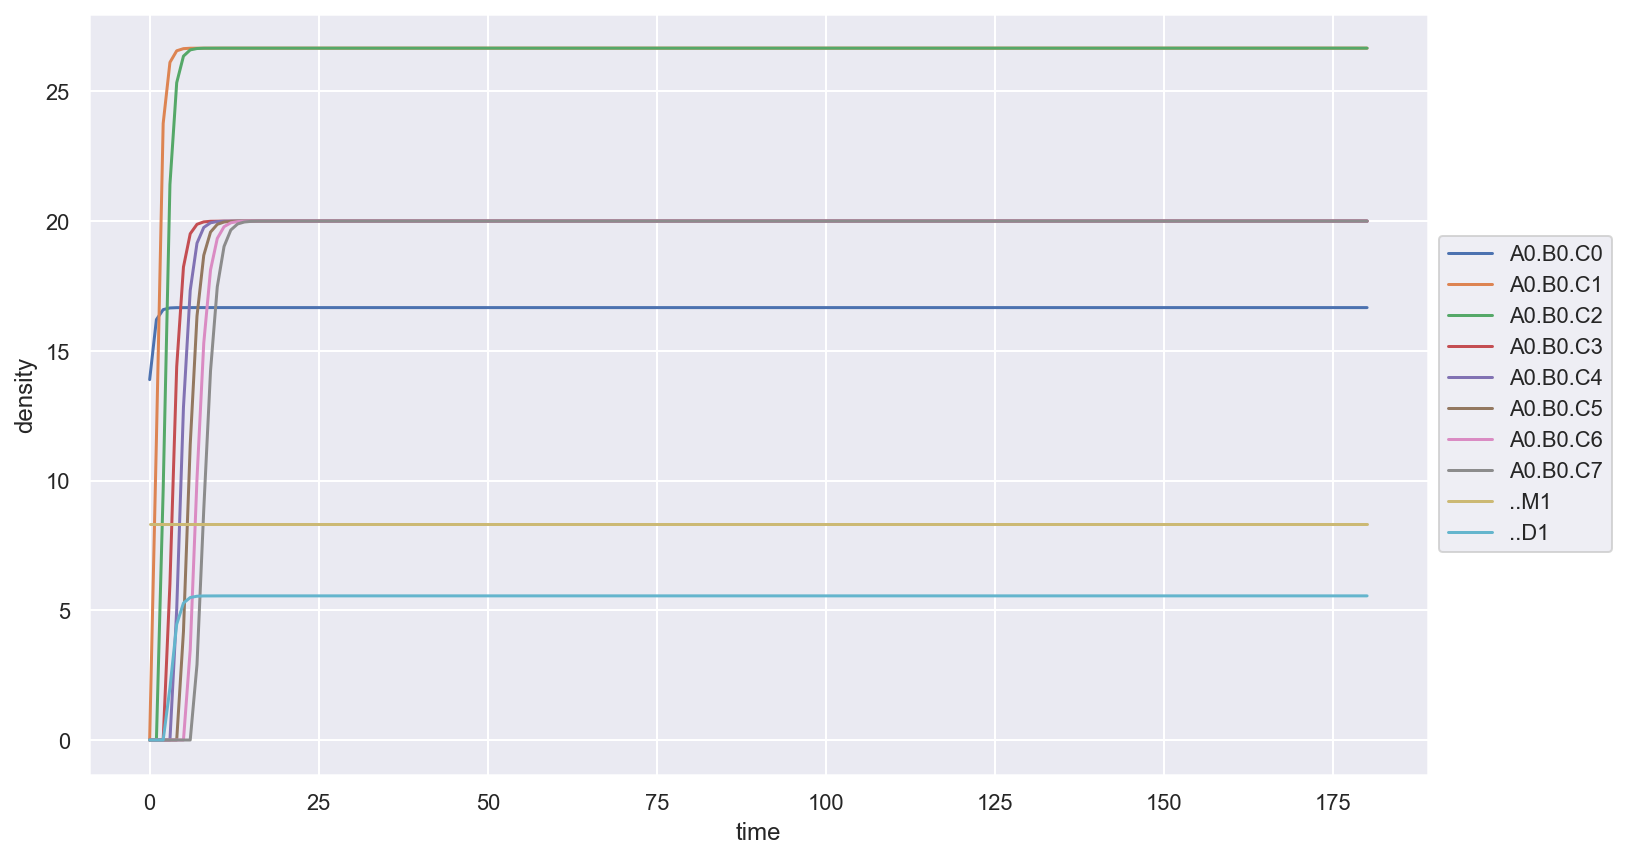

In [11]:
fig,ax = plt.subplots(figsize=(12, 7))

for name in df_flip.columns:
    ax.plot(df_flip[name], label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('time')
ax.set_ylabel('density')